# Guerra Mundial RS

## Imports
We start importing the required libraries

In [25]:
import numpy as np
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from descartes.patch import PolygonPatch
from matplotlib.collections import PatchCollection
import seaborn as sns
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
import os
import json

And initializing the visualization set

In [3]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
%matplotlib inline

## Shapefile structure

The shapefile will be directed stored inside a geopandas dataframe

In [4]:
shp_path = "./Municipio.shp"
df = geopandas.read_file(shp_path)

This is a record example structure

In [6]:
df.sample()

,nome,geocodigo,anoDeRefer,nomeAbrev,d_geometri,geometry
433,Senador Salgado Filho,4320321,1995,Senador Salgado Filho,Sim,POLYGON ((-54.59460563599998 -27.9436848669999...


## Helper functions

We will use a function to accomodate other features in Geopandas df

In [7]:
def enhance_df(df):
    """
    Add some special information to the Dataframe
    """
    
    df['owner'] = df.nome
    df['color'] = [np.random.rand(3,) / 2 + 0.5 for city_name in df.nome]
    df['protected'] = [0 for city_name in df['nome']]
    df['ranking'] = float('nan')
    df['participated'] = False
    
    return df

We have some function to compute data for each city, such as:

* the distance between two points (two city centres)
* the distance from a city to all other cities

In [8]:
def haversine_distance(p0, p1):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [p0.x, p0.y, p1.x, p1.y])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers

    return c * r

In [9]:
def distance_to_other_cities(df, city):
    """
    Returns the Haversine distance for each city
    in relation to a given city, sorted by distance
    """
    city_centre = df[df.nome == city].geometry.centroid
    distance = [(haversine_distance(city_centre, df[df.nome ==
                                                    other_city].geometry.centroid), other_city,) for other_city in df.nome]

    return sorted(distance, key=lambda x: x[0])

We also use a function to plot a single shape

In [22]:
def plot_city(df, city_name, print_text=False, **kwargs):
    """ Plots a single shape """
    
    # Fetch city
    city = df[df.nome == city_name]
    
    # Plot the shape
    city.plot(facecolor=city.color.values[0])
    
    # Configure the text plotting
    if print_text:
        center = city.geometry.centroid.values[0]
        plt.text(center.x, center.y, city_name, va='center', ha='center', **kwargs)

And a function to plot a map, and cities, by color

In [27]:
def plot_map_fill(df, 
                  x_lim = None, 
                  y_lim = None, 
                  figsize = (16,13),
                  **kwargs):
    '''
    Plot map with lim coordinates, and the cities asked with their correspondent color
    '''
    
    # Configure the plot
    fig, ax = plt.subplots(figsize = figsize)
    
    # Plot all the cities in the map (using custom code, as the fucking geopandas doesn't work correctly)
    ax.set_aspect('equal')
    collection = PatchCollection([PolygonPatch(poly['geometry'], facecolor=poly['color'], hatch='//') for (i, poly) in df.iterrows()], match_original=True)
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    
    # Configure the map size
    if x_lim is not None and y_lim is not None:
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    
    return fig, ax

# Experiments

Here we have some space to test some stuff

In [13]:
df = enhance_df(df)
df

,nome,geocodigo,anoDeRefer,nomeAbrev,d_geometri,geometry,owner,color,protected,ranking,participated
0,Quaraí,4315305,1875,Quaraí,Sim,POLYGON ((-56.04483493099997 -30.0490163699999...,Quaraí,"[0.5489150560357512, 0.9616942413697656, 0.940...",0,NaN,False
1,Tuparendi,4322301,1959,Tuparendi,Sim,POLYGON ((-54.58240537799998 -27.5892488649999...,Tuparendi,"[0.5667104194458045, 0.5473981131367283, 0.672...",0,NaN,False
2,Turuçu,4322327,1995,Turuçu,Sim,POLYGON ((-52.20587021299997 -31.3769592979999...,Turuçu,"[0.7716995056588576, 0.8996677502043591, 0.656...",0,NaN,False
3,Bom Jesus,4302303,1913,Bom Jesus,Sim,POLYGON ((-50.71894901999997 -28.2611494569999...,Bom Jesus,"[0.5688516533309023, 0.926739777334838, 0.5494...",0,NaN,False
4,Capão da Canoa,4304630,1982,Capão da Canoa,Sim,POLYGON ((-49.99179200099996 -29.6060689989999...,Capão da Canoa,"[0.6146042353818286, 0.7604743729790064, 0.975...",0,NaN,False
5,Chuvisca,4305447,1995,Chuvisca,Sim,POLYGON ((-51.97663894899995 -30.6604518129999...,Chuvisca,"[0.6647626999421242, 0.8185380787021588, 0.821...",0,NaN,False
6,Coronel Bicaco,4305900,1963,Cel. Bicaco,Sim,POLYGON ((-53.73567824199995 -27.6602816739999...,Coronel Bicaco,"[0.7552249756608735, 0.7341366160023132, 0.568...",0,NaN,False
7,Forquetinha,4308433,1996,Forquetinha,Sim,POLYGON ((-52.16307645099994 -29.3294810559999...,Forquetinha,"[0.7418264570533003, 0.8393130326261038, 0.582...",0,NaN,False
8,Fortaleza dos Valos,4308458,1982,Fortaleza dos Valos,Sim,POLYGON ((-53.28403431499999 -28.7244809079999...,Fortaleza dos Valos,"[0.9953553489144293, 0.6690558377547747, 0.667...",0,NaN,False
9,Frederico Westphalen,4308508,1954,Frederico Westphalen,Sim,POLYGON ((-53.32702393799997 -27.2217323729999...,Frederico Westphalen,"[0.6306904457329016, 0.7623208816593819, 0.773...",0,NaN,False


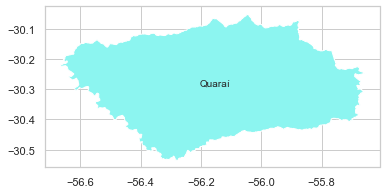

In [23]:
plot_city(df, 'Quaraí', print_text=True)

(<Figure size 1152x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15039a10>)

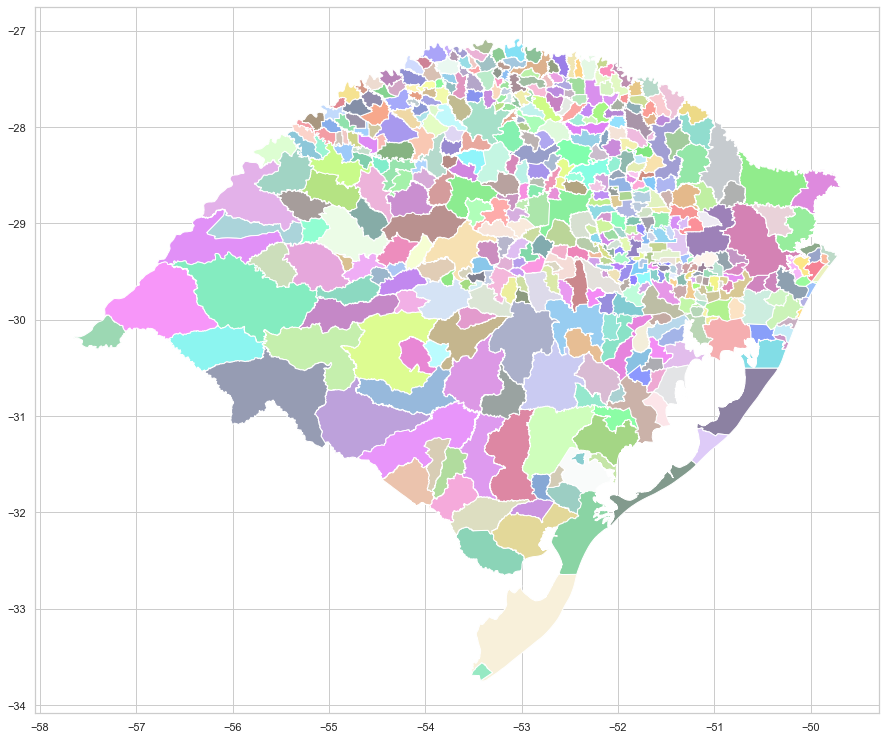

In [28]:
plot_map_fill(df, fontsize=7)

# Guerra testing

Here we try some testing seeing who will win this war

In [19]:
# Precompute the distances
if os.path.isfile('./distances.json'):
    print("Fetching distances from cached file")
    with open('./distances.json', 'r') as f:
        DISTANCES = json.load(f)
else:
    print("Computing distances")
    with tqdm(df['nome']) as t:
        for city_name in t:
            t.set_description(city_name)
            DISTANCES[city_name] = distance_to_other_cities(df, city_name)

    # Write the distances to a file
    print("Writing distances to cache file")
    with open('distances.json', 'w') as f:
        json.dump(DISTANCES, f)

Computing distances


Silveira Martins: 100%|██████████████████████████████████████████████████████████████| 497/497 [04:57<00:00,  1.82it/s]


Writing distances to cache file


In [41]:
# Re-fetch the owner
df = df.assign(owner=df.nome)
df = df.assign(color=[np.random.rand(3,) / 2 + 0.5 for city_name in df['nome']])

In [21]:
def run(*, times=1):
    for i in range(times):
        if len(df.owner.unique()) > 1:
            # Get the reference to the attacking city
            attack_city = df.sample()

            # Get the reference to the attacking city owner
            attack_city_owner = df[df.nome == attack_city.owner.to_numpy()[0]]

            # Get the attacking city name
            attack_name = attack_city.nome.to_numpy()[0]

            # Get the distance to the other cities
            distance_to_cities = DISTANCES[attack_name]

            # Get the names from all cities under the same owner
            owned_by_same = df[df.owner == attack_city_owner.nome.to_numpy()[0]].nome.to_numpy()

            # Get the name of the first city, in distance, which is not owned by the same guy
            defend_name = next(city[1] for city in distance_to_cities if city[1] not in owned_by_same and city[1])

            # Get its correspondent reference
            defend_city = df[df.nome == defend_name]

            # Get its owner
            defend_city_owner = df[df.nome == defend_city.owner.to_numpy()[0]]

            # Print information
            print("{} conquers {} from {} through {}".format(attack_city_owner.nome.to_numpy()[0], defend_name, defend_city_owner.nome.to_numpy()[0], attack_name))

            # Update the city owner
            df.loc[df['nome'] == defend_name, ['owner']] = attack_city_owner.nome.to_numpy()[0]   

    

In [44]:
run(times=1500)

Pantano Grande conquers Rio Pardo from Rio Pardo through Pantano Grande
São Jorge conquers Vanini from Vanini through São Jorge
Coqueiros do Sul conquers Almirante Tamandaré do Sul from Almirante Tamandaré do Sul through Coqueiros do Sul
Victor Graeff conquers Tio Hugo from Tio Hugo through Victor Graeff
Não-Me-Toque conquers Lagoa dos Três Cantos from Lagoa dos Três Cantos through Não-Me-Toque
Arroio do Meio conquers Lajeado from Lajeado through Arroio do Meio
Pejuçara conquers Bozano from Bozano through Pejuçara
Boa Vista das Missões conquers Jaboticaba from Jaboticaba through Boa Vista das Missões
Araricá conquers Parobé from Parobé through Araricá
Caiçara conquers Vicente Dutra from Vicente Dutra through Caiçara
Capão do Leão conquers Cerrito from Cerrito through Capão do Leão
Fortaleza dos Valos conquers Boa Vista do Incra from Boa Vista do Incra through Fortaleza dos Valos
Ivoti conquers Presidente Lucena from Presidente Lucena through Ivoti
Barracão conquers Pinhal da Serra from

Anta Gorda conquers Guaporé from União da Serra through Anta Gorda
Engenho Velho conquers Trindade do Sul from Trindade do Sul through Três Palmeiras
Rondinha conquers Sarandi from Sarandi through Rondinha
Lajeado do Bugre conquers Sagrada Família from São José das Missões through Lajeado do Bugre
Esperança do Sul conquers Derrubadas from Derrubadas through Esperança do Sul
Candelária conquers Novo Cabrais from Novo Cabrais through Candelária
Severiano de Almeida conquers Mariano Moro from Mariano Moro through Severiano de Almeida
Três de Maio conquers Boa Vista do Buricá from Boa Vista do Buricá through São José do Inhacorá
Novo Cabrais conquers Novo Cabrais from Candelária through Paraíso do Sul
Barão de Cotegipe conquers São Valentim from Entre Rios do Sul through Barão de Cotegipe
Dezesseis de Novembro conquers Roque Gonzales from Roque Gonzales through Dezesseis de Novembro
Tupanci do Sul conquers Santo Expedito do Sul from Sananduva through Tupanci do Sul
Erval Grande conquers It

Ibarama conquers Lagoa Bonita do Sul from Lagoa Bonita do Sul through Ibarama
Maquiné conquers Capão da Canoa from Xangri-Lá through Terra de Areia
Santa Vitória do Palmar conquers Arroio Grande from Arroio Grande through Santa Vitória do Palmar
Campo Bom conquers Campo Bom from Araricá through Novo Hamburgo
Pinto Bandeira conquers Bento Gonçalves from Bento Gonçalves through Pinto Bandeira
Gramado Xavier conquers Passa Sete from Passa Sete through Sinimbu
Capão Bonito do Sul conquers Lagoa Vermelha from Lagoa Vermelha through Capão Bonito do Sul
Glorinha conquers Taquara from Araricá through Santo Antônio da Patrulha
Engenho Velho conquers Cerro Grande from Cerro Grande through Três Palmeiras
Nova Bréscia conquers Encantado from Encantado through Capitão
Mato Leitão conquers Canudos do Vale from Canudos do Vale through Forquetinha
Faxinalzinho conquers Rio dos Índios from Rio dos Índios through Nonoai
Jóia conquers Boa Vista do Cadeado from Boa Vista do Cadeado through Augusto Pestana

Gramado Xavier conquers Cerro Branco from Ibarama through Vale do Sol
Entre Rios do Sul conquers São Valentim from Barão de Cotegipe through Cruzaltense
Barracão conquers Cacique Doble from Sananduva through São José do Ouro
Horizontina conquers Novo Machado from Alecrim through Doutor Maurício Cardoso
Serafina Corrêa conquers Casca from Gentil through Serafina Corrêa
Mato Leitão conquers Marques de Souza from Travesseiro through Canudos do Vale
Pinheiro Machado conquers Pedro Osório from Santa Vitória do Palmar through Pinheiro Machado
Amaral Ferrador conquers Camaquã from Camaquã through São Lourenço do Sul
Ibarama conquers Nova Palma from Pinhal Grande through Ibarama
Passo Fundo conquers Água Santa from Mato Castelhano through Mato Castelhano
Mato Leitão conquers Mato Leitão from Cruzeiro do Sul through Santa Clara do Sul
Três Arroios conquers Severiano de Almeida from Severiano de Almeida through Três Arroios
Gentil conquers Vila Maria from Montauri through Gentil
Barra do Ribeiro

Pinto Bandeira conquers Veranópolis from Veranópolis through Pinto Bandeira
Erebango conquers Cruzaltense from Entre Rios do Sul through Ponte Preta
Santo Ângelo conquers Vitória das Missões from Vitória das Missões through Santo Ângelo
Arroio Grande conquers Arroio Grande from Santa Vitória do Palmar through Rio Grande
Carazinho conquers Boa Vista do Incra from Fortaleza dos Valos through Quinze de Novembro
Glorinha conquers Sapiranga from Santa Maria do Herval through Araricá
Carazinho conquers Salto do Jacuí from Fortaleza dos Valos through Fortaleza dos Valos
Esmeralda conquers Lagoa Vermelha from Capão Bonito do Sul through Capão Bonito do Sul
Erebango conquers Vila Lângaro from Passo Fundo through Coxilha
Maçambará conquers Itaqui from Quaraí through São Borja
Carazinho conquers Cruz Alta from Jóia through Fortaleza dos Valos
Três de Maio conquers Nova Candelária from Crissiumal through Boa Vista do Buricá
Carazinho conquers Boa Vista do Cadeado from Jóia through Boa Vista do Inc

Gramado Xavier conquers Candelária from Candelária through Herveiras
Sete de Setembro conquers Salvador das Missões from Porto Vera Cruz through Cerro Largo
Capão do Cipó conquers Jóia from Mata through Eugênio de Castro
Caiçara conquers Palmitinho from Seberi through Caiçara
Porto Vera Cruz conquers Salvador das Missões from Sete de Setembro through São Paulo das Missões
Barra do Ribeiro conquers Vale Verde from Passo do Sobrado through General Câmara
Barra do Ribeiro conquers Esteio from Esteio through Nova Santa Rita
Maçambará conquers Rosário do Sul from Cacequi through Alegrete
Bagé conquers Dom Pedrito from Santa Margarida do Sul through Aceguá
Sete de Setembro conquers São Pedro do Butiá from Dezesseis de Novembro through Rolador
Faxinalzinho conquers Itatiba do Sul from Barra do Rio Azul through Erval Grande
Erebango conquers Áurea from Gaurama through Floriano Peixoto
Boa Vista das Missões conquers Pinhal from Caiçara through Boa Vista das Missões
Sananduva conquers Paim Filho

Xangri-Lá conquers Capivari do Sul from Camaquã through Tramandaí
Boa Vista das Missões conquers Sagrada Família from Nova Boa Vista through Cerro Grande
Faxinalzinho conquers Severiano de Almeida from Erebango through Três Arroios
Chuí conquers Santa Vitória do Palmar from Santa Vitória do Palmar through Chuí
Porto Vera Cruz conquers Santo Cristo from Alecrim through Porto Vera Cruz
Gentil conquers Casca from Serafina Corrêa through Santo Antônio do Palma
Carazinho conquers Arroio do Tigre from Gramado Xavier through Salto do Jacuí
Gramado Xavier conquers Tunas from Carazinho through Barros Cassal
Boa Vista das Missões conquers Novo Xingu from Nova Boa Vista through Sagrada Família
Tupandi conquers Vale Real from São Francisco de Paula through Farroupilha
Montauri conquers Vila Maria from Gentil through Montauri
Faxinalzinho conquers Benjamin Constant do Sul from Erebango through Erval Grande
Colinas conquers Westfalia from Westfalia through Teutônia
Cambará do Sul conquers Terra de A

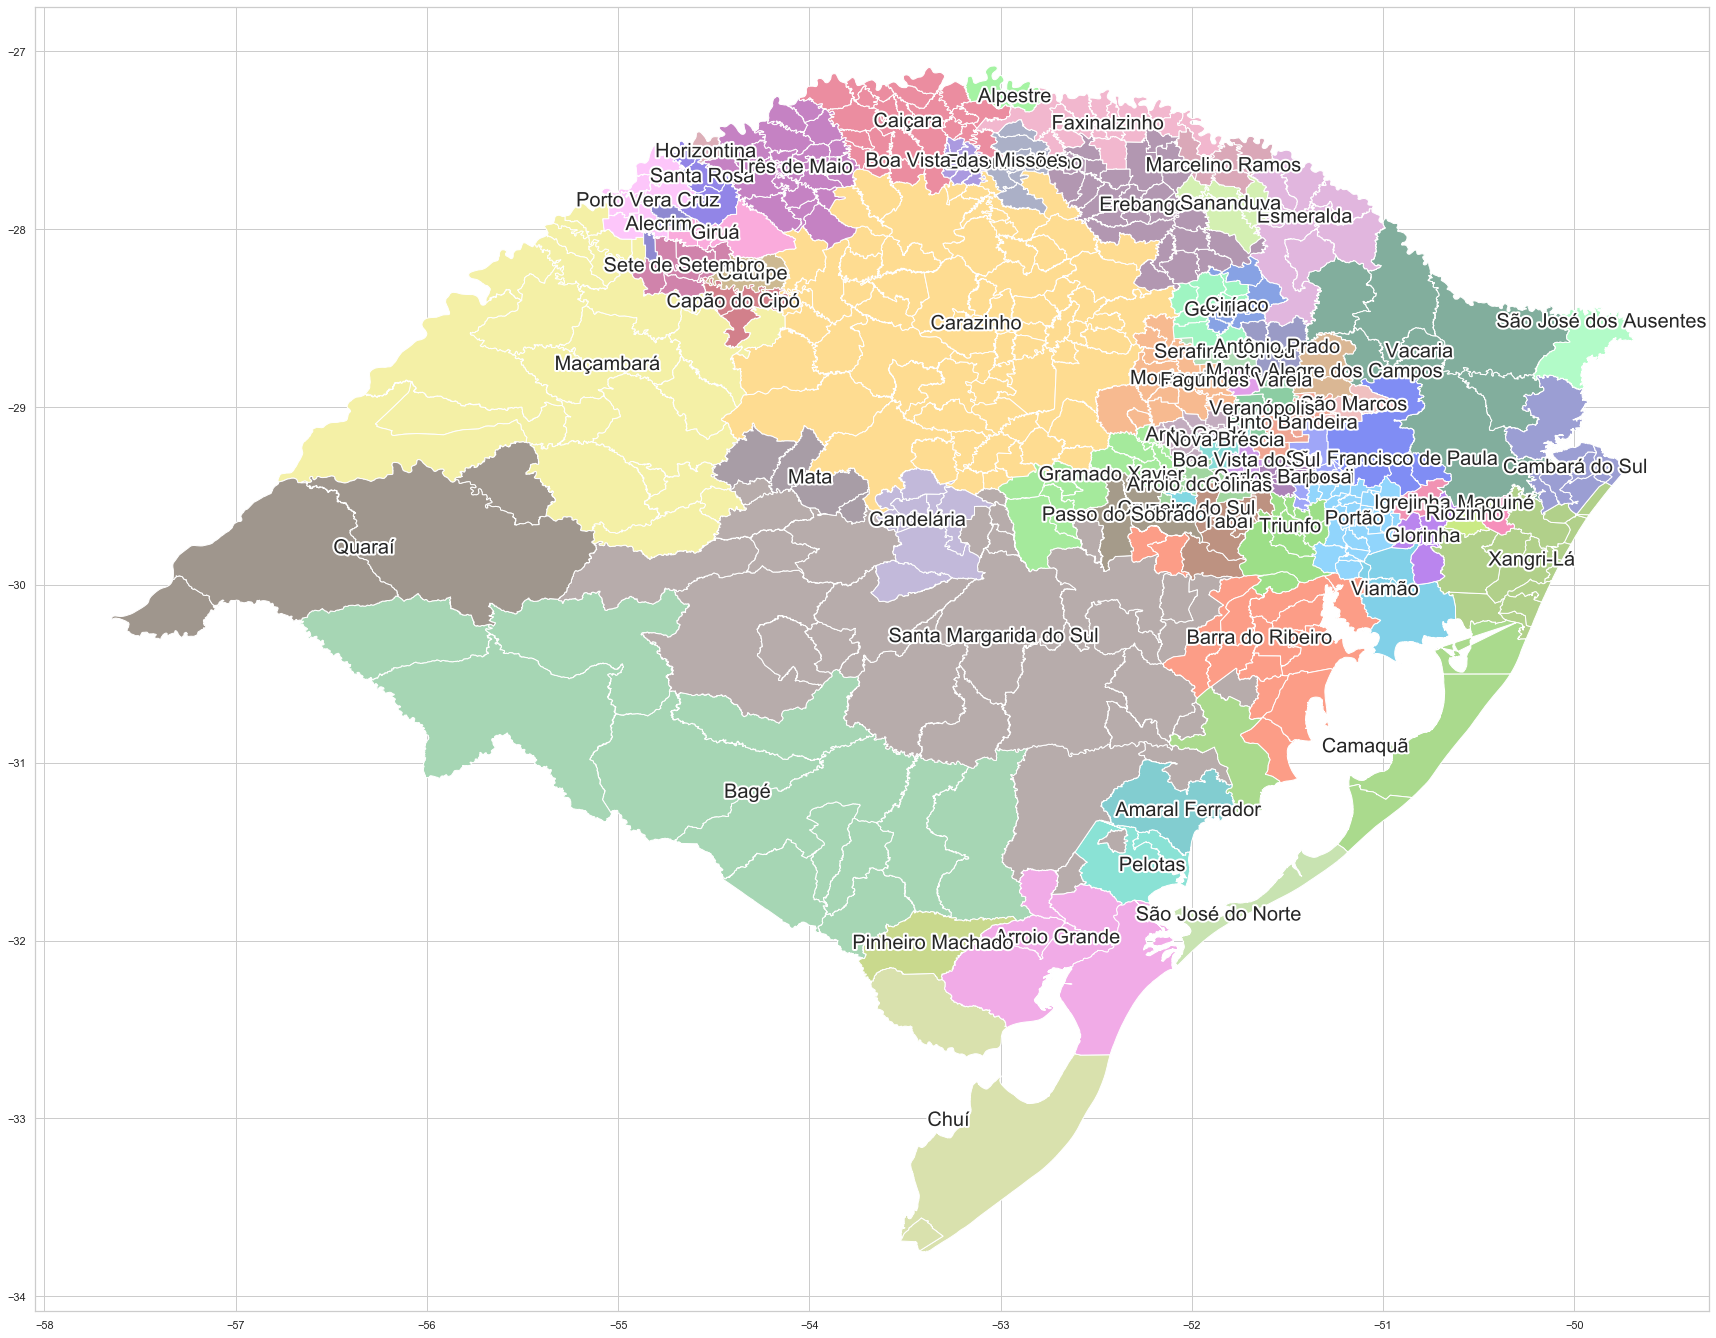

In [47]:
plot_map_fill(sf, df, fontsize=20, figsize=(30,24))